In [46]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils, cluster_utils, random_forest_utils

### Get stock data

In [47]:
query_date = '2017-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    --where ticker in ('T', 'BA', 'MMM', 'GA', 'GM', 'GE', 'AAPL', 'MSFT', 'DOW', 'AXP', 'IBM', 'JPM')
    limit 100
    ),
    raw as (
        select 
            market_datetime
            , symbol
            , sector
            , industry
            , (open + close) / 2 as average_price_today
            , volume
            , avg(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_open_hundred_days
            , avg(open) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_open_fifty_days
            , avg(open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_open_ten_days
            , max(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as high_open_hundred_days
            , min(open) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as low_open_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 100 preceding and current row) as average_volume_hundred_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 50 preceding and current row) as average_volume_fifty_days
            , avg(volume) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_volume_ten_days
            , avg((open - close)/open) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_finish_ten_days
            , avg((high - low)/high) over (partition by symbol order by market_datetime rows between 10 preceding and current row) as average_daily_range_ten_days
            , avg(open) over (partition by symbol order by market_datetime rows between 9 following and 19 following) as forward_average
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{query_date}'
        )
    select *
        , (average_open_hundred_days - average_open_fifty_days) / average_open_hundred_days 
            as hundred_fifty_average_open_diff
        , (average_open_fifty_days - average_open_ten_days) / average_open_fifty_days 
            as fifty_ten_average_open_diff
        , (high_open_hundred_days - low_open_hundred_days) / high_open_hundred_days 
            as hundred_high_low_open_diff
        , (average_volume_hundred_days - average_volume_fifty_days) / average_volume_hundred_days 
            as hundred_fifty_average_volume_diff
        , (average_volume_fifty_days - average_volume_ten_days) / average_volume_fifty_days 
            as fifty_ten_average_volume_diff
        , (forward_average - average_price_today) / average_price_today as target
    from raw
    where forward_average is not null
    and market_datetime > '{query_date}'::date + interval '10' day
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,market_datetime,symbol,sector,industry,average_price_today,volume,average_open_hundred_days,average_open_fifty_days,average_open_ten_days,high_open_hundred_days,...,average_volume_ten_days,average_daily_finish_ten_days,average_daily_range_ten_days,forward_average,hundred_fifty_average_open_diff,fifty_ten_average_open_diff,hundred_high_low_open_diff,hundred_fifty_average_volume_diff,fifty_ten_average_volume_diff,target
0,2017-01-11 06:00:00,ARE,Consumer Services,Real Estate Investment Trusts,110.440,489253.0,111.815714,111.815714,111.815714,112.66,...,4.406019e+05,0.002597,0.017997,111.950909,0.0,0.0,0.016332,0.0,0.0,0.013681
1,2017-01-11 06:00:00,BSAC,Finance,Commercial Banks,21.600,740719.0,21.960000,21.960000,21.960000,22.12,...,3.691694e+05,0.003494,0.013477,21.776364,0.0,0.0,0.024412,0.0,0.0,0.008165
2,2017-01-11 06:00:00,AGI,Basic Industries,Precious Metals,8.415,4223654.0,7.834286,7.834286,7.834286,8.30,...,3.712601e+06,-0.028808,0.071318,7.980909,0.0,0.0,0.168675,0.0,0.0,-0.051585
3,2017-01-11 06:00:00,ALK,Transportation,Air Freight/Delivery Services,93.300,2537802.0,88.754286,88.754286,88.754286,92.80,...,1.590291e+06,-0.006303,0.029335,94.345455,0.0,0.0,0.064871,0.0,0.0,0.011205
4,2017-01-11 06:00:00,CAT,Capital Goods,Construction/Ag Equipment/Trucks,94.560,3720504.0,93.638571,93.638571,93.638571,94.47,...,4.049210e+06,0.001547,0.015978,95.816364,0.0,0.0,0.016301,0.0,0.0,0.013286


### Explore data

In [48]:
df['market_datetime_int'] = df['market_datetime'].astype(int)

df = cluster_utils.encode_one_hot(df, ['symbol', 'sector', 'industry'])

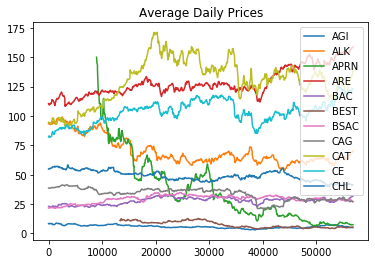

In [49]:
cluster_utils.groupby_plot(df=df, 
                           groupby='symbol', 
                           column='average_price_today', 
                           title='Average Daily Prices')

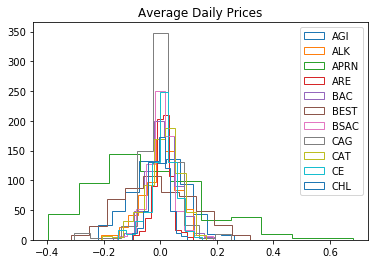

In [50]:
cluster_utils.groupby_plot(df=df, 
                           groupby='symbol', 
                           column='target', 
                           title='Average Daily Prices',
                           plot_type='histogram')

### Build random forest

#### Target: Open Price 10 Days from Now

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


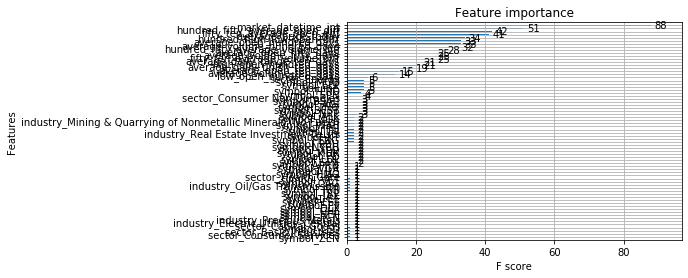

In [51]:
temp = df.copy()

# y = temp.groupby('symbol')['percent_diff'].shift(-1)
y = temp['target']

x = temp[~y.isna()].reset_index(drop=True)
y = y[~y.isna()].reset_index(drop=True)

split = .8
cutoff = int(len(x) * .8)

train_x = x.iloc[:cutoff]
test_x = x.iloc[cutoff:]

train_y = y.iloc[:cutoff]
test_y = y.iloc[cutoff:]

cols_to_ignore = ['symbol', 'sector', 'industry', 'market_datetime', 'forward_average', 'target']

boost = random_forest_utils.XGBooster(train_x=train_x, 
                                      train_y=train_y,
                                      test_x=test_x,
                                      test_y=test_y,
                                      objective='reg:squarederror',
                                      max_depth=4,
                                      n_estimators=50,
                                      gamma=.01,
                                      columns_to_ignore=cols_to_ignore
                                     )

boost.fit()
boost.predict()
boost.mse

# boost.plot_prediction(prediction)
# boost.plot_prediction_error(prediction)
boost.plot_importance()

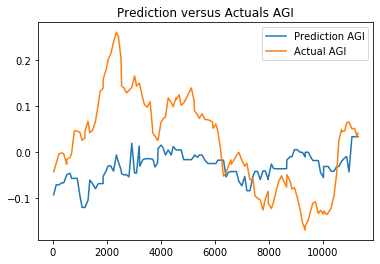

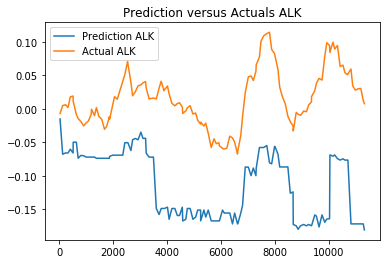

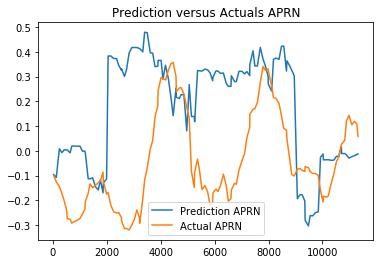

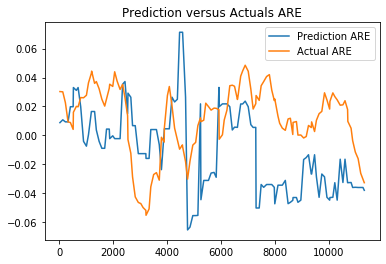

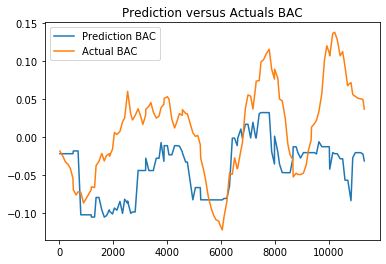

In [52]:
boost.plot_prediction_groupby(groupby='symbol', 
                              title='Prediction versus Actuals', 
                              n_plots=4,
                              n_ticks=10)

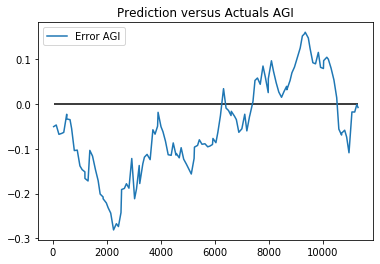

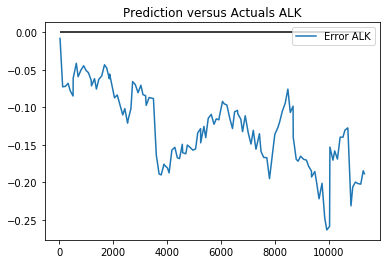

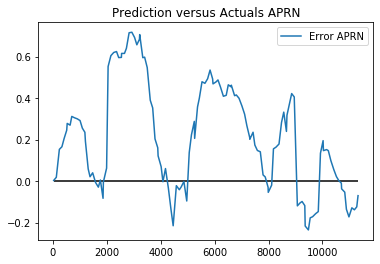

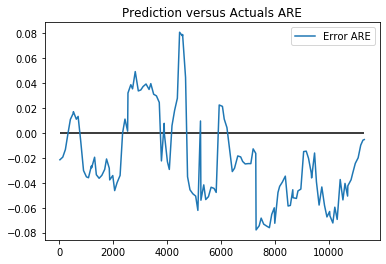

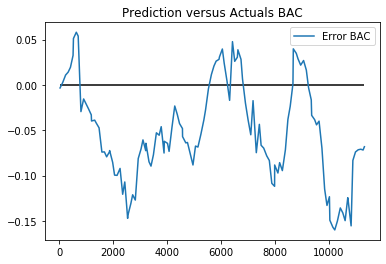

In [53]:
boost.plot_prediction_groupby(groupby='symbol', 
                              title='Prediction versus Actuals', 
                              n_plots=4, 
                              error_plot=True)

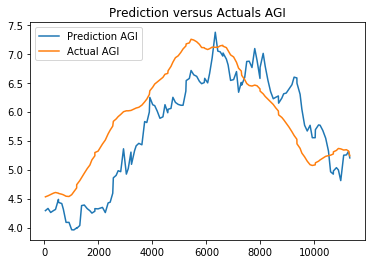

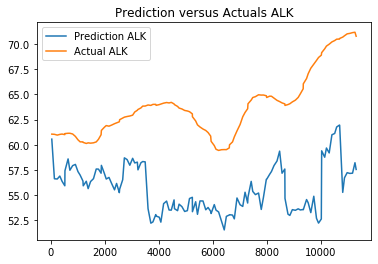

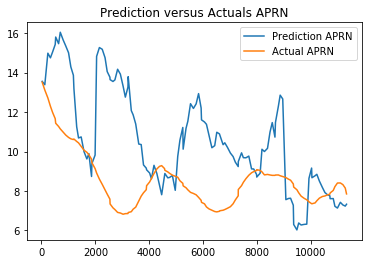

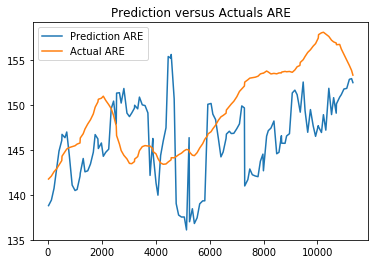

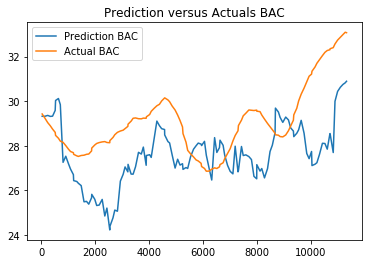

In [54]:
output = boost.output
output['prediction_price'] = (1 + output['prediction']) * output['average_price_today']

boost.plot_prediction_groupby(prediction='prediction_price',
                              actuals='forward_average',
                              groupby='symbol',
                              title='Prediction versus Actuals',
                              n_plots=4,
                              df=output
                             )

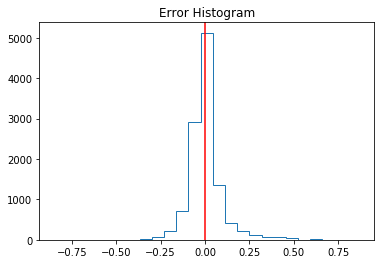

In [55]:
plt.hist(boost.output['prediction']-boost.output['target'], bins=25, histtype='step')
plt.title('Error Histogram')
plt.axvline(0, color='r')
plt.show()

In [56]:
output.loc[output['symbol']==output['symbol'][0],
           ['market_datetime', 'average_price_today', 'forward_average', 
            'prediction_price', 'target', 'prediction']
          ].head(30)

,market_datetime,average_price_today,forward_average,prediction_price,target,prediction
0,2019-04-17 05:00:00,105.815,109.886364,104.538109,0.038476,-0.012067
68,2019-04-18 05:00:00,105.780,110.165455,105.611588,0.041458,-0.001592
173,2019-04-22 05:00:00,105.655,110.466364,104.380040,0.045538,-0.012067
188,2019-04-23 05:00:00,106.075,110.996364,104.794972,0.046395,-0.012067
302,2019-04-24 05:00:00,107.485,111.408182,107.313873,0.036500,-0.001592
366,2019-04-25 05:00:00,107.730,111.800909,108.032876,0.037788,0.002811
454,2019-04-26 05:00:00,108.735,112.265455,109.040701,0.032468,0.002811
562,2019-04-29 05:00:00,108.205,112.835455,109.740889,0.042793,0.014194
669,2019-04-30 05:00:00,108.550,113.338182,109.059623,0.044110,0.004695
740,2019-05-01 05:00:00,109.380,113.643636,109.893519,0.038980,0.004695
